# Finding a Good Configuration for each of the datasets
In this part of the assignment, the aim is to find a good hyperparameter set that performs well in the given datasets. For each of the datasets, a different hyperparameter set is defined. The optimized parameters are as follows:
- Using a hidden layer or not
- Activation function: One of ReLU, Sigmoid, LeakyReLU, Tanh
- Loss Function used: Either MSE (Mean Squared Error), or BCE (Binary Cross Entropy)
- Learning rate value
- Weight initialization range: The models use an uniform distribution in range (-weight_range, weight_range) in the implementation, the weight_range parameter is an hyperparameter here
- Number of epochs
- Using Momentum or not
- Learning Algorithm: Either Stochastic Gradient Descent or Batch Gradient Descent
- Normalizing data or not

### Necessary imports
To run this experiment, the necessary libraries are numpy and matplotlib library. The modules named as ann and dataset_setup are personal implementations and can be found in submission file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ann import *
from dataset_setup import *

## Importing Datasets
To provide ease of running, the *dataset_setup.py* module enables downloading txt dataset files easily. The mentioned file uses wget, shutil and os modules to download and save the dataset files in txt form. By usign this functionality, th dataset can be obtained easily.

In [2]:
DATA_FILE_NAMES = ["train1", "test1", "train2", "test2"]
BASE_URL = "http://www.cs.bilkent.edu.tr/~gunduz/teaching/cs550/documents"
FILE_URLS = [os.path.join(BASE_URL, file_name) for file_name in DATA_FILE_NAMES]

file_paths = download_data(DATA_FILE_NAMES, FILE_URLS)

dataset_1 = Dataset(file_paths[0], file_paths[1])
dataset_2 = Dataset(file_paths[2], file_paths[3])


DOWNLOAD COMPLETED


In [3]:
print(file_paths)

['/Users/yusufdalva/Desktop/CS Bilkent/2020 Fall/CS 550/CS550_Assignments/HW2/data/train1.txt', '/Users/yusufdalva/Desktop/CS Bilkent/2020 Fall/CS 550/CS550_Assignments/HW2/data/test1.txt', '/Users/yusufdalva/Desktop/CS Bilkent/2020 Fall/CS 550/CS550_Assignments/HW2/data/train2.txt', '/Users/yusufdalva/Desktop/CS Bilkent/2020 Fall/CS 550/CS550_Assignments/HW2/data/test2.txt']


## Results for the first dataset
The following part shows the reuslts for the first dataset. Various alternatives are tried out for this dataset and a fitting line found as a result of that. The results are shown on samples drawn from an uniform distribution that has the upper and lower bounds of the first dataset. The samples are determined cosnidering the training set, rather than the test set for maximum and minimum value. The following function shows the implementation of the uniform distribution using numpy.

In [4]:
def draw_uniform_samples(data, no_of_samples):
    max_values = np.max(data, axis=0)
    min_values = np.min(data, axis=0)
    dist = np.random.uniform(min_values[0], max_values[0], no_of_samples)
    return dist

#### Plotting Loss Values
To observe whether the network learns or not, the loss values obtained are plotted with the following function

In [5]:
def plot_losses(losses):
    epoch_count = len(losses)
    plt.plot(range(1, epoch_count + 1), losses)
    plt.title("Loss vs Epoch Count", fontsize=14)
    plt.ylabel("Loss", fontsize=10)
    plt.xlabel("Epoch", fontsize=10)

#### Plotting Predictions
Using the uniform samples obtained from the function *draw_uniform_samples*, the learned model plotted with the function given below.

In [6]:
def plot_predictions(samples, dist_count, model, title, data_label, loc):
    dist = draw_uniform_samples(samples, dist_count)
    dist = np.reshape(dist, (len(dist), 1))
    y_pred = model.predict(dist)
    sort = list(sorted(zip(dist, y_pred)))
    dist, y_pred = zip(*sort)
    plt.title(title, fontsize=14)
    plt.xlabel("x", fontsize=10)
    plt.ylabel("y", fontsize=10)
    plt.scatter(samples[:, 0], samples[:, 1], label=data_label)
    plt.plot(dist, y_pred, label="Learned model", c="red", lw=2.5)
    plt.legend(loc=loc, borderaxespad=1.0)

#### Visualizing the hidden units
In order to observe what contribution that the hidden units make, the learned units are visualized. For doing this, the weights for the hidden layer are used by the sample points drawn from a uniform distribution. Similar to visualizing the learned model, this method also draws uniform samples using the min-max value of the given data distribution.

In [28]:
def visualize_units(train_samples, model, title):
    if len(model.layers) != 2:
        print("This model does not contain any hidden units")
        return
    dist = draw_uniform_samples(train_samples, 500)
    dist = dist.reshape((len(dist), 1))
    unit_weights = model.layers[0].weights
    unit_out = np.dot(unit_weights, dist.T) + model.layers[0].bias
    unit_out = model.layers[0].activation(unit_out, stage="forward")
    p = dist.flatten().argsort()
    dist = dist[p]
    unit_out = unit_out.T[p]
    for unit_idx in range(unit_out.shape[1]):
        plt.xlabel("x", fontsize=10)
        plt.ylabel("y", fontsize=10)
        plt.title(title, fontsize=14)
        plt.plot(dist.flatten(), unit_out[:, unit_idx])

#### Getting the Loss Value
In order to assess the loss value after training, in addition to the losses returned by the *fit* function, a final assesment has been made. This method also reports the standard deviation of the loss values among the predictions made in the dataset.

In [8]:
def get_loss(data, model):
    labels = data[:, 1]
    samples = data[:, 0]
    samples = np.reshape(samples, (len(samples), 1))
    y_pred = model.predict(samples)
    print("Standard Deviation of loss: {:.4f}".format(np.std(model.loss(labels, y_pred, stage="forward"), axis=0)))
    loss = np.sum(model.loss(labels, y_pred, stage="forward"), axis=0) / len(labels)
    return loss

#### Effect of normalization
To see the effects of nomalization, the normalization is done prior to fitting the data. The datasets store their mean and standard deviation values, which allows ease of normalizing and denormalizing data. The normalization is performed with the following formula:<br>
$\Large{Z = \frac{X - \mu}{\sigma}}$<br>Here the X value is the original data value, Z is the normalized value. With the normalization, the dataset will have 0.0 mean and 1.0 standard deviation. The normalization and denormalizatio operations can be done by *normalize_data* and *denormalize_data* functions in the dataset class.

### Trying out linear regressor
In order to find a good model for the first dataset, first the model that does not involve any nonlinerity. This is perform to examine the limits of a linear regressor in terms of predictive performance. For both linear and nonlinear alternatives a seperate optimization is done to observe the limits of the models.

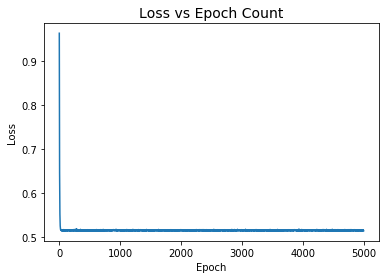

In [9]:
linear_network = ANN(input_dim=1, weight_range=0.001, hidden_layer_enabled=False)
normalized_train, normalized_test = dataset_1.normalize_data()
linear_losses = linear_network.fit(normalized_train, 5000, learning_rate=0.001, update="sgd", momentum_enabled=True, alpha=0.1)
plot_losses(linear_losses)

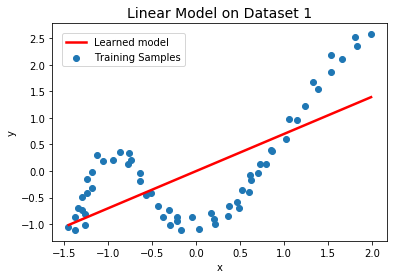

In [10]:
plot_predictions(normalized_train, 500, linear_network, "Linear Model on Dataset 1", "Training Samples", loc="upper left")

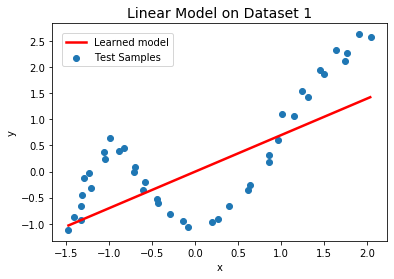

In [11]:
plot_predictions(normalized_test, 500, linear_network, "Linear Model on Dataset 1", "Test Samples", loc="upper left")

### ANN with one hidden layer
As it is observed that linear regressor was not able to perform well on predicting such a non-linear distribution, the ANN with one hidden layer is expected to perform better. The model constructed is as follows.

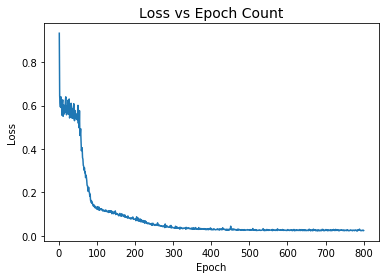

In [12]:
nonlinear_network = ANN(input_dim=1, weight_range=0.0003, loss="mse", hidden_layer_enabled=True, hidden_units=5, activation="tanh")
normalized_train, normalized_test = dataset_1.normalize_data()
nonlinear_losses = nonlinear_network.fit(normalized_train, 800, learning_rate=0.01, update="sgd", momentum_enabled=True, alpha=0.1)
plot_losses(nonlinear_losses)

As it can be observed from the shape and the values of the loss function, the model achieves cnvergence with one hidden layer containing 5 hidden units. Considering that the minimum value of the loss function is 0, the model does a good job on learning the distribution. This success can be observed from the plots given for training and test samples given below. Here the performance on test set also shows the success of the model in terms of generalization.

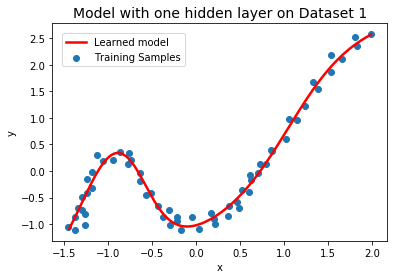

In [13]:
plot_predictions(normalized_train, 500, nonlinear_network, "Model with one hidden layer on Dataset 1", "Training Samples", loc="upper left")

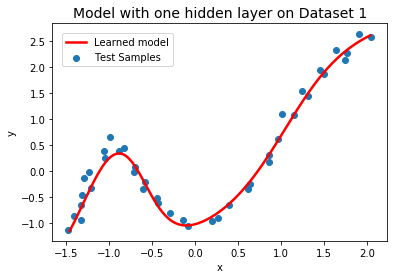

In [14]:
plot_predictions(normalized_test, 500, nonlinear_network, "Model with one hidden layer on Dataset 1", "Test Samples", loc="upper left")

#### Visualization of the hidden units
Since the dataset involves non-linear parts, the tanh function has been used. The patterns that are learned by the hidden units can be obseved from the plot given below. Here to observe a good fit, each of these non-linear parts of the model has been captured by a hidden unit. After that by using a linear layer, these non-linear results are combined to observe the fitted line observed as the learned model.

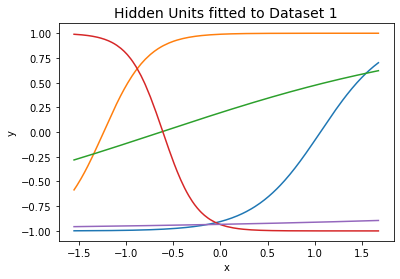

In [30]:
visualize_units(normalized_train, nonlinear_network, "Hidden Units fitted to Dataset 1")

#### Reporting the Loss values
To complete the optimization stage the training and the test set losses are reported. For this model MSE loss is used to assess the model performance, the formulation is as follows:<br>
$\Large{\frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2}$<br>
The losses for training and test set and the standard deviations of these losses are reported as follows.

In [18]:
print("TRAINING SET")
print("Training Loss: {:.4f}".format(get_loss(normalized_train, nonlinear_network)))
print("TEST SET")
print("Test Loss: {:.4f}".format(get_loss(normalized_test, nonlinear_network)))

TRAINING SET
Standard Deviation of loss: 0.0408
Training Loss: 0.0216
TEST SET
Standard Deviation of loss: 0.0469
Test Loss: 0.0284


## Results for the second Dataset
After observing that th model with one hidden layer gives better predictive results compared to linear regression model, it is concluded that hidden layers give the power of fitting a regression line which is not linear. Considering that the nonlinearity of the second dataset is higher (shown in *Data Exploration.ipynb*), the ANN model with one hidden layer is expected to give better results.

### A good model for dataset 2
After conducting several experiments, the following model is constructed which fits to dataset 2 well. The plots for the constructed model is given below.

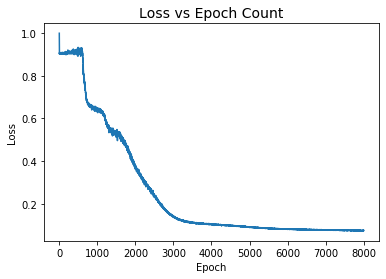

In [23]:
dataset_2_model = ANN(input_dim=1, weight_range=0.0003, loss="mse", hidden_layer_enabled=True, hidden_units=16, activation="tanh")
normalized_train, normalized_test = dataset_2.normalize_data()
dataset_2_losses = dataset_2_model.fit(normalized_train, 8000, learning_rate=0.001, update="sgd", momentum_enabled=True, alpha=0.1)
plot_losses(dataset_2_losses)

Compared to the first dataset due to the existance of the more non-linear regions (also differing types) and the existing local mininas on the second dataset, the model took longer to learn. In order to overcome these regiosn a smaller learning rate and more hidden units has been used. At the end of training the convergence pattern is also observed, which is clear with the change of loss values plot given above. To illustrate the results, the learned curve visualized both on test set and training set. The obtained curves are given below.

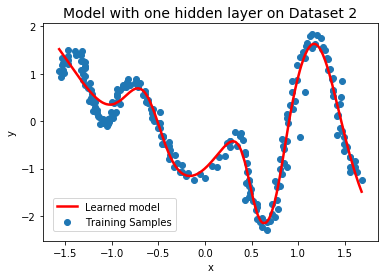

In [24]:
plot_predictions(normalized_train, 500, dataset_2_model, "Model with one hidden layer on Dataset 2", "Training Samples", loc="lower left")

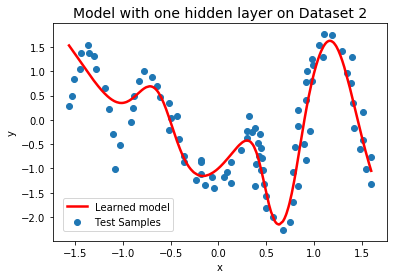

In [25]:
plot_predictions(normalized_test, 500, dataset_2_model, "Model with one hidden layer on Dataset 2", "Test Samples", loc="lower left")

#### Visualizing the hidden units
Just like for the first dataset, the learned non-linearities are visulaized by using random uniform data samples points and making a predicton with them with model weights. Here it can be seen that the different non-linearities are captured by different hidden units. By combining these units linearly, the finalized learned model is formed. The visualization of the different hidden units are gicen below.

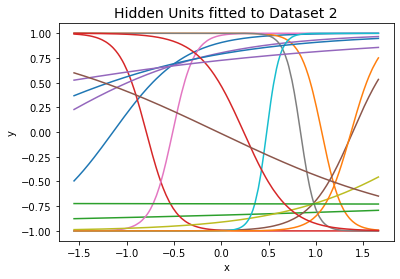

In [29]:
visualize_units(normalized_train, dataset_2_model, "Hidden Units fitted to Dataset 2")

#### Reporting the loss values
Concluding the analysis regarding the second dataset, the loss values obtained in the training set and the test set are reported as follows. The standard deviation of these loss values are ablo reported. Here different from the first dataset, there is some difference on the test loss and training set. This is due to that the learned model does not fit the test samples perfectly but shows considerably good performance on training data. The densites of the samples on different curves also effect this. As it can be seen, the places where most of the points in the trainig set are located are predicted better considering the properties of MSE loss.

In [27]:
print("TRAINING SET")
print("Training Loss: {:.4f}".format(get_loss(normalized_train, dataset_2_model)))
print("TEST SET")
print("Test Loss: {:.4f}".format(get_loss(normalized_test, dataset_2_model)))

TRAINING SET
Standard Deviation of loss: 0.1709
Training Loss: 0.0733
TEST SET
Standard Deviation of loss: 0.3269
Test Loss: 0.2022
